In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [ ]:
# Load the dataset
df = pd.read_csv('Gold2.csv')

# Add a decision column - This is a simple strategy based on the high price in the day
df['decision'] = 'Hold'

# Simple strategy: Buy when price is lower than a threshold and Sell when it is higher
# You can experiment with moving averages or other thresholds here
threshold = df['Close/Last'].mean()  # A simple threshold to decide buy/sell

df.loc[df['Close/Last'] < threshold, 'decision'] = 'Buy'
df.loc[df['Close/Last'] > threshold, 'decision'] = 'Sell'

# Convert decision to numerical values for training (0 = Hold, 1 = Buy, 2 = Sell)
df['decision'] = df['decision'].map({'Hold': 0, 'Buy': 1, 'Sell': 2})

# Check the data
df.head()


,Unnamed: 0,Close/Last,Volume,Open,High,Low,day,month,year,decision
0,0,1915.2,146770.0,1922.4,1933.5,1914.2,17,8,2023,2
1,1,1928.3,124766.0,1933.1,1938.2,1922.0,16,8,2023,2
2,2,1935.2,161512.0,1939.4,1944.3,1927.5,15,8,2023,2
3,3,1944.0,117514.0,1945.6,1948.2,1934.2,14,8,2023,2
4,4,1946.6,119090.0,1944.9,1953.6,1942.7,11,8,2023,2


In [ ]:
class DecisionTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, n_heads, n_layers):
        super(DecisionTransformer, self).__init__()

        # Define a linear layer to project the input dimension to match the hidden dimension
        self.input_projection = nn.Linear(input_dim, hidden_dim)

        # Define transformer encoder layers
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=hidden_dim,
                nhead=n_heads
            ),
            num_layers=n_layers
        )

        # Output layer to make predictions
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Project the input to the hidden dimension
        x = self.input_projection(x)

        # Transformer expects batch_first=True
        x = x.transpose(0, 1)  # Switch to [sequence_length, batch_size, hidden_dim]

        # Apply the transformer encoder
        x = self.encoder(x)

        # Take the output from the last time step
        x = x[-1]

        # Make the final prediction
        x = self.fc(x)
        return x


In [ ]:
# Extract features and labels
features = df[['Close/Last', 'Volume', 'Open', 'High', 'Low', 'day', 'month', 'year']].values
labels = df['decision'].values

# Standardize the features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Convert features and labels to PyTorch tensors
features_tensor = torch.FloatTensor(features)
labels_tensor = torch.LongTensor(labels)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features_tensor, labels_tensor, test_size=0.2, random_state=42)

# Reshaping the input to match the transformer input expectations: [batch_size, sequence_length, feature_size]
X_train = X_train.unsqueeze(1)  # Add sequence dimension, reshape to [batch_size, 1, feature_size]
X_test = X_test.unsqueeze(1)    # Same reshaping for the test set

# Check the shape of the reshaped data
print(X_train.shape)  # Should print [batch_size, 1, feature_size]


torch.Size([2031, 1, 8])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [50/500], Loss: 0.0087
Epoch [100/500], Loss: 0.0034
Epoch [150/500], Loss: 0.0043
Epoch [200/500], Loss: 0.0025
Epoch [250/500], Loss: 0.0013
Epoch [300/500], Loss: 0.0012
Epoch [350/500], Loss: 0.0006
Epoch [400/500], Loss: 0.0015
Epoch [450/500], Loss: 0.0003
Epoch [500/500], Loss: 0.0002


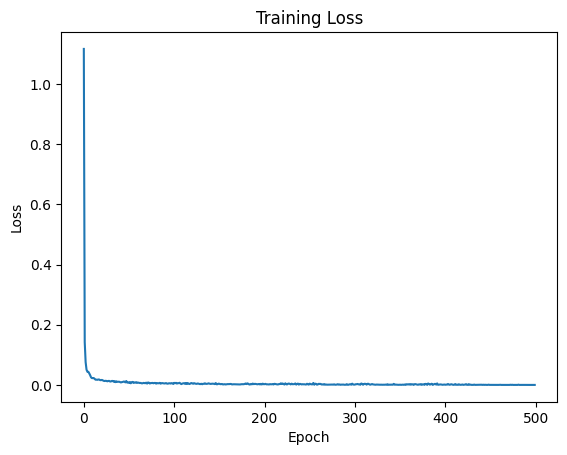

In [ ]:
# Initialize model, loss function, and optimizer
model = DecisionTransformer(input_dim=features.shape[1], output_dim=3, hidden_dim=64, n_heads=4, n_layers=2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 500
train_losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)

    # Compute the loss
    loss = criterion(outputs, y_train)
    loss.backward()

    # Update parameters
    optimizer.step()

    train_losses.append(loss.item())

    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Plot the training loss
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import torch

# Assuming X_test is a tensor where the first column is 'Close/Last' prices
# Reshape X_test to 2D by squeezing the extra dimension
X_test_reshaped = X_test.squeeze(1)  # Remove the extra dimension (1 in shape)

# Convert the reshaped data to a pandas DataFrame to calculate moving averages
data = pd.DataFrame(X_test_reshaped.numpy(), columns=['Close/Last', 'Volume', 'Open', 'High', 'Low', 'Day', 'Month', 'Year'])

# Define moving averages for strategy
short_window = 5
long_window = 15

# Calculate short and long-term moving averages
data['SMA_short'] = data['Close/Last'].rolling(window=short_window).mean()
data['SMA_long'] = data['Close/Last'].rolling(window=long_window).mean()

# Simulate the trades and calculate profit
initial_balance = 10000  # Starting with $10,000
balance = initial_balance
owned_gold = 0
buy_price = 0

# Loop over each day in the test data and simulate the trade
for i in range(len(data)):
    current_price = data['Close/Last'][i]

    # Buy condition: Price is below short-term moving average (buy low)
    if current_price < data['SMA_short'][i] and balance > 0:
        owned_gold = balance / current_price  # Buy gold with all available balance
        balance = 0  # Balance is now zero after buying
        buy_price = current_price  # Track the price at which gold was bought

    # Sell condition: Price is above long-term moving average (sell high)
    elif current_price > data['SMA_long'][i] and owned_gold > 0:
        balance = owned_gold * current_price  # Sell all owned gold for the current price
        owned_gold = 0  # After selling, no gold left

# Calculate the final profit
total_profit = balance - initial_balance
print(f'Total profit: ${total_profit:.2f}')


Total profit: $-10000.00
